# Introduction


In this notebook, I create a model for forecasting stock prices which takes into account not only historical data and technical indicators, but also such external factors influencing the market as the mood of traders and brand reputation, which is represented in social media posts.

Reference: 
https://www.kaggle.com/code/vsmanichrome/stock-prediction-twitter-sentiment-analysis
https://www.youtube.com/watch?v=CbTU92pbDKw

# Table of contents
1. [Import packages](#section-one)
1. [Get weekly sentiment for stock ticker](#section-two)
1. [Data Preparation](#section-three)
1. [Model Implementation](#section-four)
1. [Model Tuning](#section-five)
1. [Final Results](#section-six)

<a id="section-one"></a>
# Import packages

In [ ]:
%pip install tensorflow
%pip install pydot
%pip install graphviz

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import tensorflow as tf

from tensorflow.keras.layers import GRU, LSTM, Bidirectional,Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
import keras.utils
from keras.utils import plot_model

In [7]:
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

<a id="section-two"></a>
# Get weekly sentiment for stock ticker

We will obtain the sentiment data from Twitter. The data will be processed to obtain the sentiment score.  

In [8]:
all_tweets = pd.read_csv('D:\DSBA_Sem 3\CP2\dataset\stock_tweets.csv')

In [9]:
print(all_tweets.shape)
all_tweets['Stock Name'].unique()

(80793, 4)


array(['TSLA', 'MSFT', 'PG', 'META', 'AMZN', 'GOOG', 'AMD', 'AAPL',
       'NFLX', 'TSM', 'KO', 'F', 'COST', 'DIS', 'VZ', 'CRM', 'INTC', 'BA',
       'BX', 'NOC', 'PYPL', 'ENPH', 'NIO', 'ZS', 'XPEV'], dtype=object)

In [10]:
df = all_tweets # Rename
print(df.shape)
df.head()

(80793, 4)


,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [11]:
df['Stock Name'].value_counts() #Count the occurence

Stock Name
TSLA    37422
TSM     11034
AAPL     5056
PG       4089
AMZN     4089
MSFT     4089
NIO      3021
META     2751
AMD      2227
NFLX     1727
GOOG     1291
PYPL      843
DIS       635
BA        399
COST      393
INTC      315
KO        310
CRM       233
XPEV      225
ENPH      216
ZS        193
VZ        123
BX         50
NOC        31
F          31
Name: count, dtype: int64

We will analyze the stock for TSLA, AAPL and GOOG.

In [12]:
stock_names = ['AAPL', 'TSLA', 'GOOG']

In [13]:
sent_df = df.copy()
sent_df["sentiment_score"] = ''
sent_df["Negative"] = ''
sent_df["Neutral"] = ''
sent_df["Positive"] = ''
sent_df.head()

,Date,Tweet,Stock Name,Company Name,sentiment_score,Negative,Neutral,Positive
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",,,,
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",,,,
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc.",,,,
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc.",,,,
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc.",,,,


To get sentiment (polarity) scores, we use **VADER (Valence Aware Dictionary for Sentiment Reasoning)** model. VADER is a model used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion. It is available in the NLTK package and can be applied directly to unlabeled text data.

VADER sentimental analysis relies on a dictionary that maps lexical features to emotion intensities known as sentiment scores. The sentiment score of a text can be obtained by summing up the intensity of each word in the text.

In [14]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Boon Si
[nltk_data]     Xian\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [15]:
%%time
# Initialize the sentiment analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()
for indx, row in sent_df.iterrows():
    try:
        # Normalize the tweet text
        sentence_i = unicodedata.normalize('NFKD', row['Tweet'])
        # Get the sentiment score
        sentence_sentiment = sentiment_analyzer.polarity_scores(sentence_i)
        # Assign the sentiment scores to the dataframe
        sent_df.at[indx, 'sentiment_score'] = sentence_sentiment['compound']
        sent_df.at[indx, 'Negative'] = sentence_sentiment['neg']
        sent_df.at[indx, 'Neutral'] = sentence_sentiment['neu']
        sent_df.at[indx, 'Positive'] = sentence_sentiment['pos']
        
    except TypeError:
        print (sent_df.loc[indexx, 'Tweet'])
        print (indx)
        break

CPU times: total: 12.7 s
Wall time: 42.2 s


**The US Stock market is open from 9:30 a.m. to 4 p.m. EST, sentiment_during_trading_hrs, sentiment_after_trading_hrs**

In [16]:
sent_df = sent_df.drop(columns=['Company Name']) 

In [17]:
sent_df.head()

,Date,Tweet,Stock Name,sentiment_score,Negative,Neutral,Positive
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,0.0772,0.127,0.758,0.115
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,0.0,0.0,1.0,0.0
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,0.296,0.0,0.951,0.049
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,-0.7568,0.273,0.59,0.137
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,-0.875,0.526,0.474,0.0


In [18]:
# Define a function to filter DataFrame based on time range
def filter_time_range(df, start_time, end_time):
    df['Date'] = pd.to_datetime(df['Date'])

    # Create the Time column from the data 
    df['Time'] = df['Date'].dt.time
    df['DateTime'] = df['Date'].dt.strftime('%Y-%m-%d') + ' ' + df['Time'].astype(str)
    df['DateTime'] = pd.to_datetime(df['DateTime'])

    #Return the rows that are within start and end time.
    return df[(df['Time'] >= start_time) & (df['Time'] <= end_time)] 
    
# Define the time ranges in UTC
start_time_est = pd.Timestamp('05:30:00').time()
end_time_est = pd.Timestamp('12:30:00').time()

# Filter DataFrame for two different time ranges
df_within_time_range = filter_time_range(sent_df, start_time_est, end_time_est)
df_outside_time_range = sent_df[~sent_df.index.isin(df_within_time_range.index)] 
#Returns those that are not in the time range  

# df_within_time_range['Date'] = pd.to_datetime(df_within_time_range['Date'])
df_within_time_range['Date'] = df_within_time_range['Date'].dt.date

# df_outside_time_range['Date'] = pd.to_datetime(df_outside_time_range['Date'])
df_outside_time_range['Date'] = df_outside_time_range['Date'].dt.date

# Aggregate sentiment scores for both time ranges 
result_within_time_range = df_within_time_range.groupby(['Stock Name', 'Date']).agg({'sentiment_score': ['mean', 'min', 'max', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]}).reset_index()
result_within_time_range.columns = ['Stock Name', 'Date', 'Mean', 'Min', 'Max', '25th Percentile', '75th Percentile']

result_outside_time_range = df_outside_time_range.groupby(['Stock Name', 'Date']).agg({'sentiment_score': ['mean', 'min', 'max', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]}).reset_index()
result_outside_time_range.columns = ['Stock Name', 'Date', 'Mean', 'Min', 'Max', '25th Percentile', '75th Percentile']

print("Results for time range between 5:30 AM EST to 12:30 PM EST:")
print(result_within_time_range)

print("\nResults for time range outside 5:30 AM EST to 12:30 PM EST:")
print(result_outside_time_range)


Results for time range between 5:30 AM EST to 12:30 PM EST:
     Stock Name        Date    Mean     Min     Max  25th Percentile  \
0          AAPL  2021-09-30  0.2739  0.2296  0.3182          0.25175   
1          AAPL  2021-10-07  0.1484     0.0   0.368          0.03860   
2          AAPL  2021-10-08  0.7842  0.7778  0.7906          0.78100   
3          AAPL  2021-10-10  0.3612  0.3612  0.3612          0.36120   
4          AAPL  2021-10-13 -0.4278 -0.4278 -0.4278         -0.42780   
...         ...         ...     ...     ...     ...              ...   
2503         ZS  2022-08-30     0.0     0.0     0.0          0.00000   
2504         ZS  2022-09-01  0.7351  0.7351  0.7351          0.73510   
2505         ZS  2022-09-17  0.8271  0.8271  0.8271          0.82710   
2506         ZS  2022-09-21  0.5122  0.5122  0.5122          0.51220   
2507         ZS  2022-09-29     0.0     0.0     0.0          0.00000   

      75th Percentile  
0             0.29605  
1             0.22260  
2  

In [19]:
# Merge results on 'Stock Name' and 'Date'
merged_result = pd.merge(result_within_time_range, result_outside_time_range, on=['Stock Name', 'Date'], suffixes=('_sentiment_intraday', '_outside'))

print(merged_result)

     Stock Name        Date Mean_sentiment_intraday Min_sentiment_intraday  \
0          AAPL  2021-09-30                  0.2739                 0.2296   
1          AAPL  2021-10-07                  0.1484                    0.0   
2          AAPL  2021-10-08                  0.7842                 0.7778   
3          AAPL  2021-10-10                  0.3612                 0.3612   
4          AAPL  2021-10-13                 -0.4278                -0.4278   
...         ...         ...                     ...                    ...   
2335         ZS  2022-01-07                  0.4927                 0.4927   
2336         ZS  2022-02-01                     0.0                    0.0   
2337         ZS  2022-02-22                     0.0                    0.0   
2338         ZS  2022-05-21                 -0.3382                -0.3382   
2339         ZS  2022-09-01                  0.7351                 0.7351   

     Max_sentiment_intraday  25th Percentile_sentiment_intraday

In [20]:
# return a day before the news
# SOD: start of day
# shift(-1) will move the values in the column 1 position upwards.
 
merged_result['Mean_sentiment_before_sod']=merged_result['Mean_outside'].shift(-1) 
merged_result['Min_sentiment_before_sod']=merged_result['Min_outside'].shift(-1)
merged_result['Max_sentiment_before_sod']=merged_result['Max_outside'].shift(-1)
merged_result['25th Percentile_sentiment_before_sod']=merged_result['25th Percentile_outside'].shift(-1)
merged_result['75th Percentile_sentiment_before_sod']=merged_result['75th Percentile_outside'].shift(-1)
merged_result.reset_index(level=0, inplace=True)



In [21]:
# Drop not used columns
tweet_ds = merged_result.drop(['25th Percentile_outside', '75th Percentile_outside', 'Mean_outside', 'Min_outside', 'Max_outside', '25th Percentile_sentiment_intraday', '75th Percentile_sentiment_intraday', '25th Percentile_sentiment_before_sod', '75th Percentile_sentiment_before_sod'], axis=1)

In [22]:
tweet_ds.head()


,index,Stock Name,Date,Mean_sentiment_intraday,Min_sentiment_intraday,Max_sentiment_intraday,Mean_sentiment_before_sod,Min_sentiment_before_sod,Max_sentiment_before_sod
0,0,AAPL,2021-09-30,0.2739,0.2296,0.3182,0.39536,0.0,0.6892
1,1,AAPL,2021-10-07,0.1484,0.0,0.368,0.32482,0.0,0.8538
2,2,AAPL,2021-10-08,0.7842,0.7778,0.7906,0.231475,-0.4215,0.8597
3,3,AAPL,2021-10-10,0.3612,0.3612,0.3612,-0.01315,-0.5859,0.2023
4,4,AAPL,2021-10-13,-0.4278,-0.4278,-0.4278,0.516231,0.0,0.893


As the result of sentiment analysis we get average polarity scores of all tweets about a cartain stock ticker for each day:

<a id="section-three"></a>
# Data Preparation

In [23]:
# Get the stock data
all_stocks = pd.read_csv('D:\DSBA_Sem 3\CP2\dataset\stock_yfinance_data.csv') 

print(all_stocks.shape)
all_stocks.head()
all_stocks['Stock Name'].unique()


(6300, 8)


array(['TSLA', 'MSFT', 'PG', 'META', 'AMZN', 'GOOG', 'AMD', 'AAPL',
       'NFLX', 'TSM', 'KO', 'F', 'COST', 'DIS', 'VZ', 'CRM', 'INTC', 'BA',
       'BX', 'NOC', 'PYPL', 'ENPH', 'NIO', 'ZS', 'XPEV'], dtype=object)

In [24]:
all_stocks


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA
...,...,...,...,...,...,...,...,...
6295,2022-09-23,13.090000,13.892000,12.860000,13.710000,13.710000,28279600,XPEV
6296,2022-09-26,14.280000,14.830000,14.070000,14.370000,14.370000,27891300,XPEV
6297,2022-09-27,14.580000,14.800000,13.580000,13.710000,13.710000,21160800,XPEV
6298,2022-09-28,13.050000,13.421000,12.690000,13.330000,13.330000,31799400,XPEV


In [25]:
# We filter it and select only the target stock.
stock_df = all_stocks[all_stocks['Stock Name'].isin(stock_names)]
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].dt.date

In [26]:
stock_df.columns
stock_df['Stock Name'].unique()

array(['TSLA', 'META', 'GOOG', 'AAPL'], dtype=object)

In [27]:
final_df = pd.merge(stock_df, tweet_ds, on=['Stock Name', 'Date'])
#final_df = final_df.drop(columns=['Stock Name'])
print(final_df.shape)

(612, 15)


In [28]:
final_df['Stock Name'].value_counts()

Stock Name
TSLA    252
AAPL    174
META    100
GOOG     86
Name: count, dtype: int64

In [30]:
final_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,index,Mean_sentiment_intraday,Min_sentiment_intraday,Max_sentiment_intraday,Mean_sentiment_before_sod,Min_sentiment_before_sod,Max_sentiment_before_sod
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA,1654,0.228995,-0.9423,0.8331,0.21787,-0.8689,0.9313
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA,1655,0.277408,-0.8176,0.9305,0.272467,-0.8217,0.9632
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA,1658,0.07683,-0.5766,0.7278,0.090785,-0.8885,0.9467
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA,1659,0.009139,-0.875,0.7003,0.219249,-0.6908,0.9732
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA,1660,0.147529,-0.5267,0.8122,0.187267,-0.9169,0.923


In [31]:
def event_return(df):
    
    # Create new features 
    # Computing the return
    df['close_pct_change'] = df['Close'].pct_change()
    df['vol_pct_change'] = df['Volume'].pct_change()
    
    df['high_low_diff'] = df['High'] - df['Low']
    df['open_close_diff'] = df['Open'] - df['Close']

    df.reset_index(level=0, inplace=True)

event_return(final_df)

In [33]:
cpc = final_df['close_pct_change'].dropna()
min(cpc)

-0.2546708636149343

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

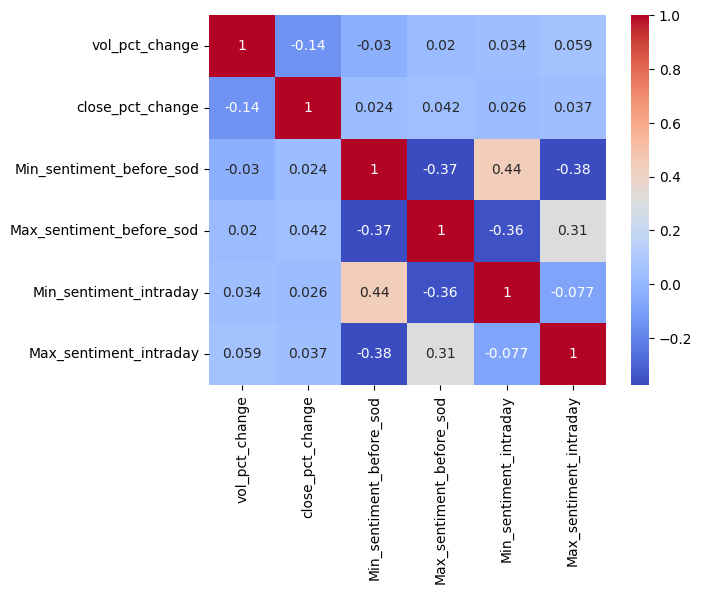

In [35]:
# Create heatmap to visualize the correlation

related_cols = ['vol_pct_change', 'close_pct_change', 'Min_sentiment_before_sod', 'Max_sentiment_before_sod', 'Min_sentiment_intraday', 'Max_sentiment_intraday']
sns.heatmap(final_df[related_cols].corr(), annot=True, cmap='coolwarm')
plt.show()


In [36]:
# Define a function to apply the condition element-wise

def classify_movement(change):
    if change > 0.05:
        return 1
    elif change < -0.05:
        return -1
    else :
        return 0
# Apply the function to each value in the 'close_pct_change' column
final_df['market_movement'] = final_df['close_pct_change'].apply(classify_movement)

In [37]:
final_df['market_movement'].value_counts()

market_movement
 0    517
-1     54
 1     41
Name: count, dtype: int64

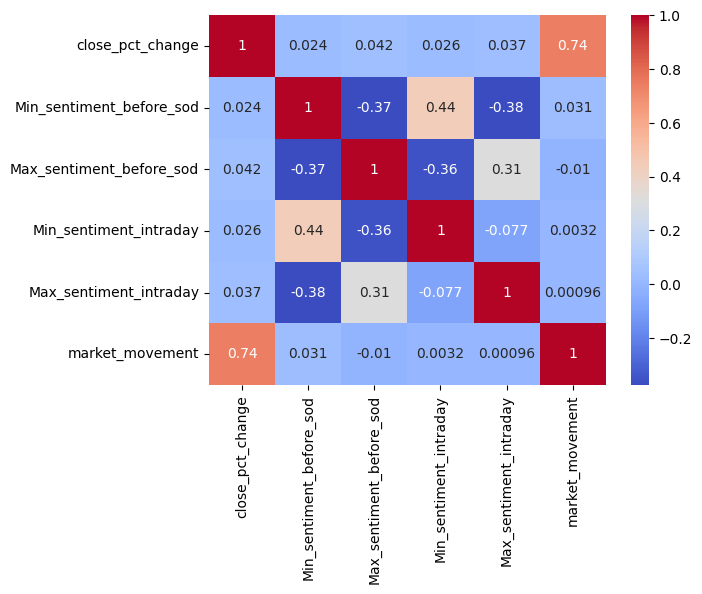

In [38]:
final_df['market_movement'].value_counts()
required_cols = ['close_pct_change', 'Min_sentiment_before_sod', 'Max_sentiment_before_sod', 'Min_sentiment_intraday', 'Max_sentiment_intraday', 'market_movement']

final_market_df = final_df[required_cols]
sns.heatmap(final_market_df[required_cols].corr(), annot=True, cmap='coolwarm')
plt.show()

**Data Preprocessing**

In [39]:
# Handling missing values
final_market_df.dropna(inplace=True) 

# Resetting index
final_market_df.reset_index(drop=True, inplace=True)


## **Preform Prediction on Market Movement via ML**

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define the required columns and the target variable
required_cols = ['close_pct_change', 'Min_sentiment_before_sod', 'Max_sentiment_before_sod', 
                 'Min_sentiment_intraday', 'Max_sentiment_intraday']
target_col = 'market_movement'

# Splitting the data into features (X) and target variable (y)
X = final_market_df[required_cols]
y = final_market_df[target_col]

# Splitting the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier()



**Random forest classifier**

In [41]:
# Train the classifier
rf_classifier.fit(X_train, y_train)

RandomForestClassifier()

In [42]:
# Predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


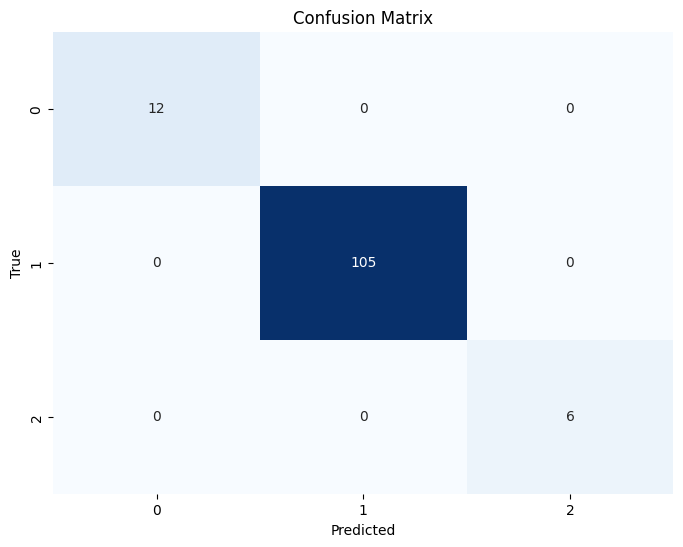

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are defined as in your example
# y_pred = rf_classifier.predict(X_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


**Logistic regression**

In [44]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression model
log_reg = LogisticRegression()



In [45]:
# Train the model
log_reg.fit(X_train, y_train)



LogisticRegression()

In [46]:
# Predictions on the test set
y_pred_log = log_reg.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_log)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8536585365853658


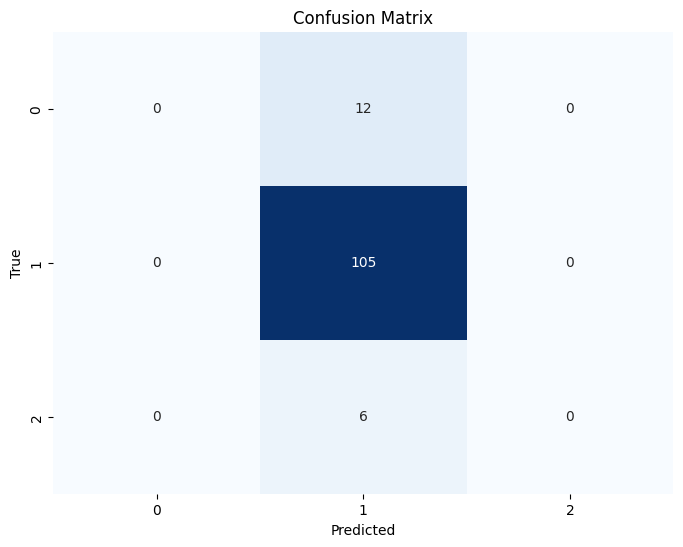

In [47]:
# Calculate confusion matrix
cm_log = confusion_matrix(y_test, y_pred_log)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Let's plot historical price data for the analyzed stock ticker:

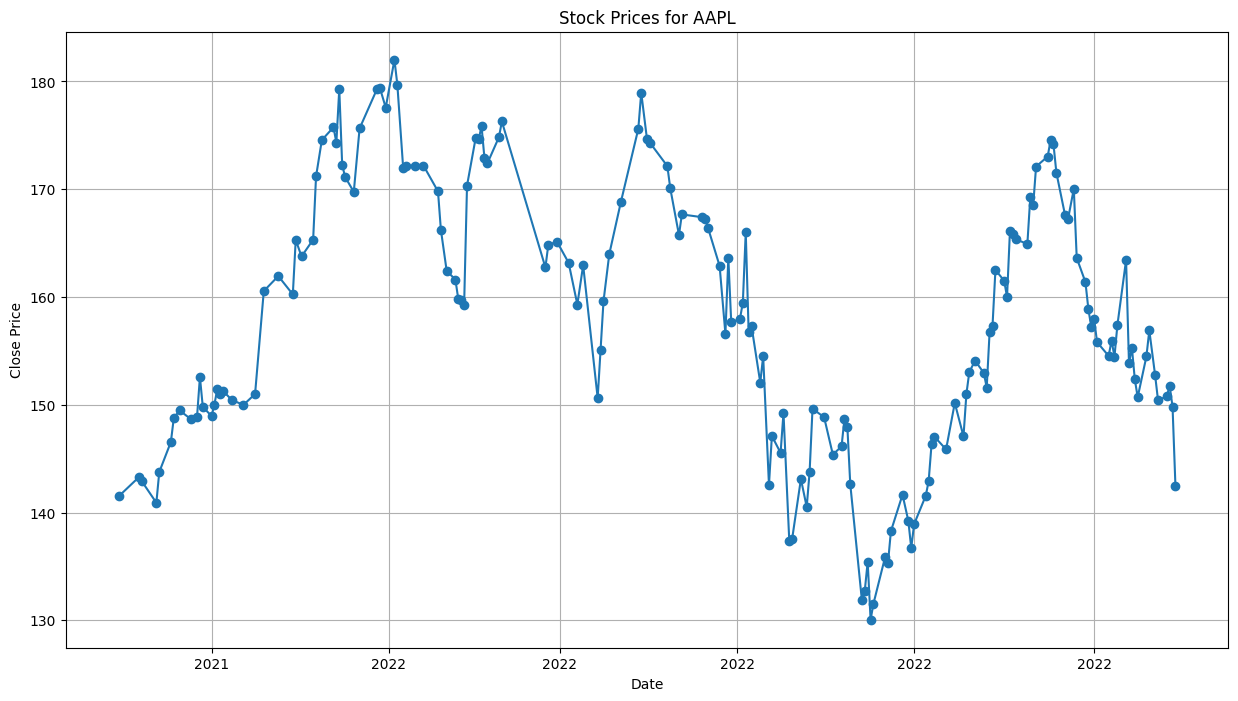

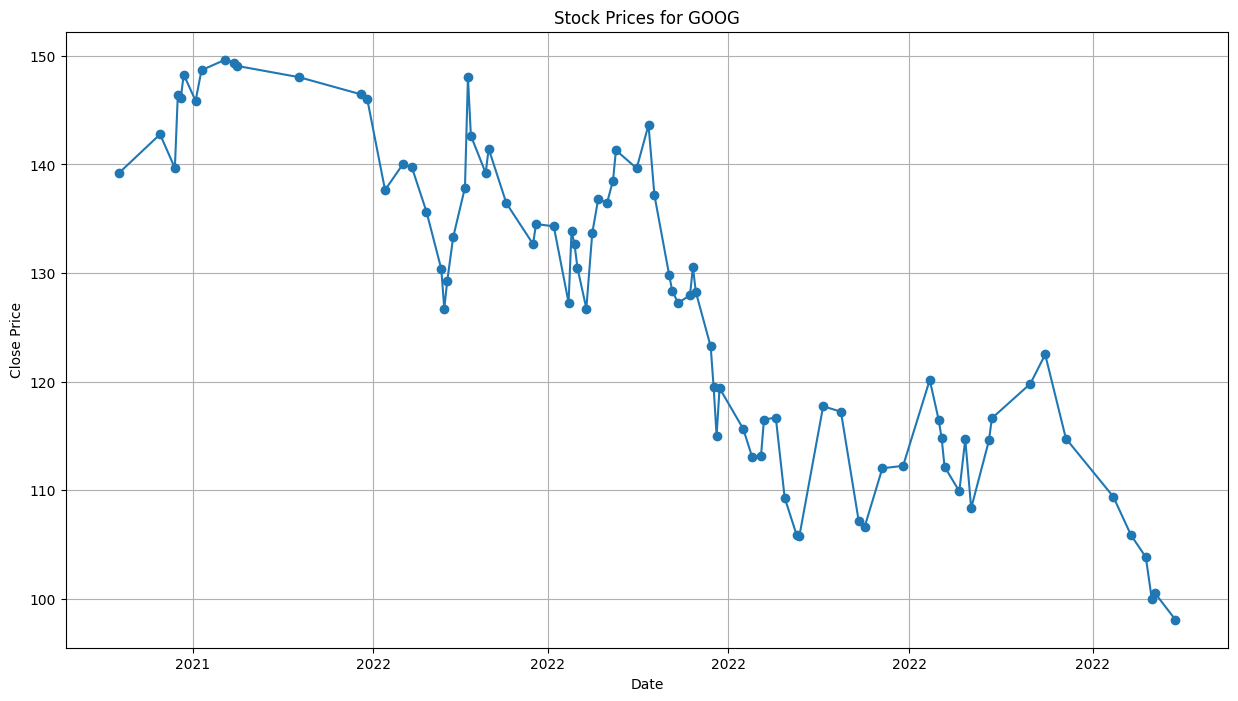

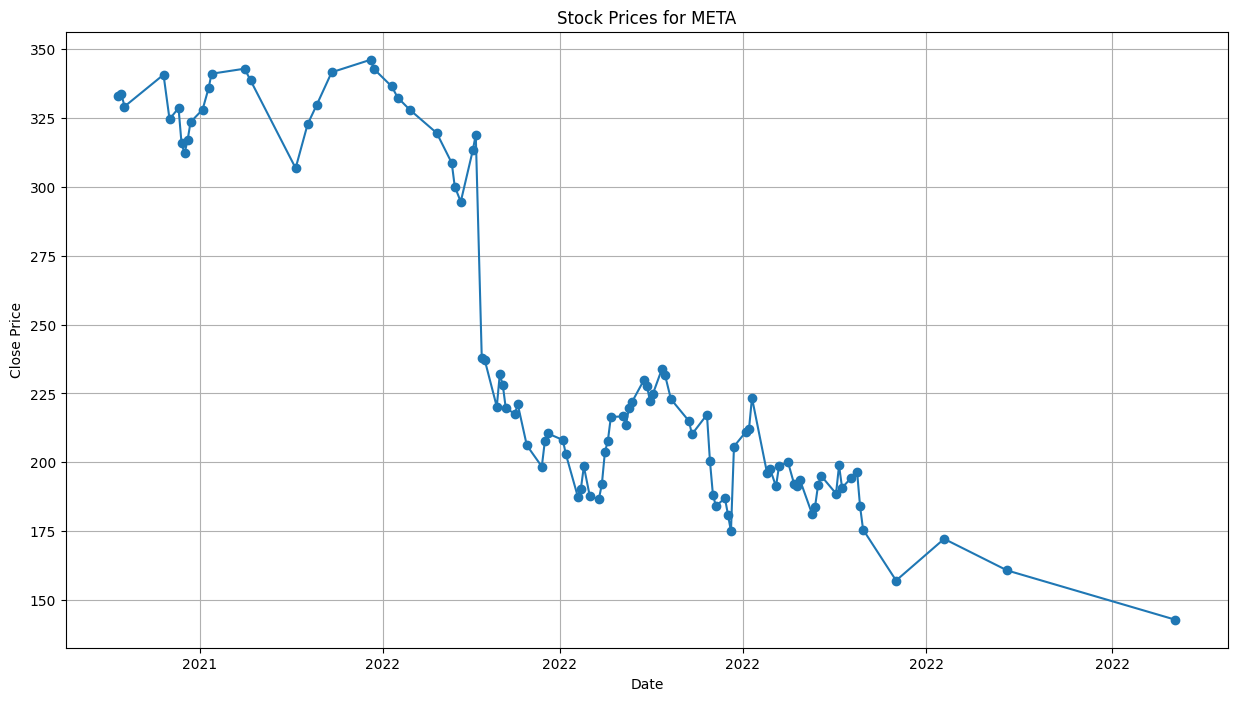

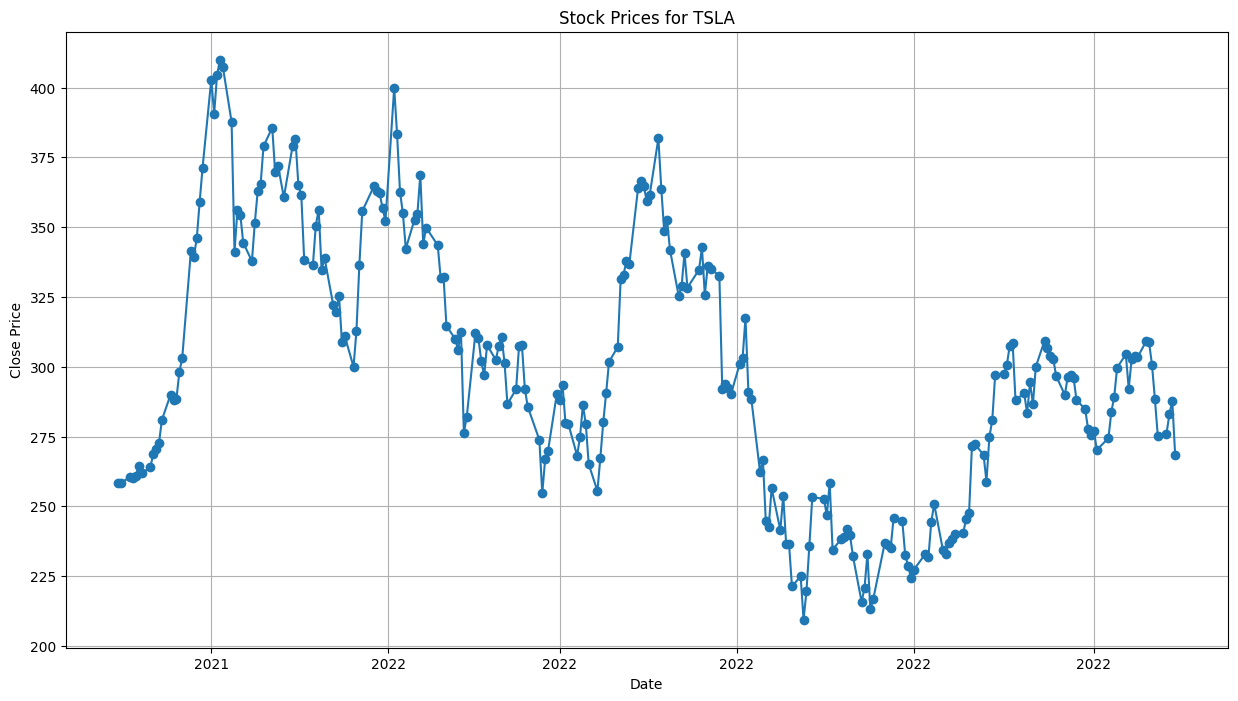

In [52]:
grouped=final_df.groupby('Stock Name')

for name, group in grouped:
    plt.figure(figsize=(15,8))
    plt.plot(group['Date'], group['Close'], marker='o')
    plt.title(f'Stock Prices for {name}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(DateFormatter("%Y"))
    plt.show()

In [53]:
AAPL = final_df[final_df['Stock Name']== 'AAPL']
GOOG = final_df[final_df['Stock Name']== 'GOOG']
META = final_df[final_df['Stock Name']== 'META']
TSLA = final_df[final_df['Stock Name']== 'TSLA']

#Seperate the data 
# so that we can add in the technical indicator smoothly.


### Adding technical indicators

To help the network understand the bigger picture of the market we add different technical indicators to the training data, such as moving averages, Bollinger bands etc., which describe the development of stock price not only for the current day, but for the past week or more.

**MA(7)** stans for Moving Average for past 7 days, whereas **MA(20)** means Moving Average for past 20 days.

**EMA** is Exponential Moving average and we can calculate it as:
* *EMA_t = Pclose + (EMA_t-1 * (100 - P))*

**Bollinger Bands** are calculated as:
* middle line: *stdev(MA(20))*
* upper bound: *MA(20) + 2stdev(MA(20))*
* lower bound: *MA(20) - 2stdev(MA(20))*

In [55]:
def get_tech_ind(data):
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean() #Close column
    data['MA20'] = data.iloc[:,4].rolling(window=20).mean() #Close Column

    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()
    #This is the difference of Closing price and Opening Price

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    #Create RSI
    data['RSI']=calculate_rsi(data)
    
    return data


In [56]:

def calculate_rsi(data, window=14):
    # Calculate price changes
    delta = data['Close'].diff()

    # Separate gains and losses
    gain = (delta.where(delta > 0, 0))
    loss = (-delta.where(delta < 0, 0))
    
    # Calculate the average gain and loss
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    
    # Compute the relative strength (RS)
    rs = avg_gain / avg_loss

    # Compute the RSI
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

In [57]:
AAPL.drop(columns='level_0', inplace=True) #Inplace helps to keep the changes for the dataset. 

In [231]:
tech_df = get_tech_ind(AAPL)
AAPL_ds = tech_df.iloc[20:,:].reset_index(drop=True)
AAPL_ds.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,Mean_sentiment_intraday,Min_sentiment_intraday,...,market_movement,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum,RSI
0,2021-11-19,157.649994,161.020004,156.529999,160.550003,159.623566,117305600,AAPL,0.8159,0.8159,...,1,152.244289,149.010001,-0.279722,4.225760,157.461522,140.558481,157.280129,5.072357,74.229377
1,2021-11-24,160.750000,162.139999,159.639999,161.940002,161.005569,69463600,AAPL,-0.10705,-0.4404,...,0,153.737146,149.942502,-0.790862,4.900909,159.744319,140.140684,160.386711,5.081032,74.920029
2,2021-11-29,159.369995,161.190002,158.789993,160.240005,159.315369,88748200,AAPL,0.3612,0.3612,...,0,155.062860,150.809502,-1.111753,5.118424,161.046351,140.572654,160.288907,5.070413,72.428485
3,2021-11-30,159.990005,165.520004,159.919998,165.300003,164.346176,174048100,AAPL,0.7096,0.7096,...,0,157.065717,152.029002,-0.993084,5.525053,163.079109,140.978896,163.629638,5.101694,76.782823
4,2021-12-02,158.740005,164.199997,157.800003,163.759995,162.815063,136739200,AAPL,0.10115,0.0,...,0,158.968573,153.029002,-0.771967,5.754804,164.538611,141.519394,163.716542,5.092277,69.610925


In [ ]:
tech_df.drop(columns='index',inplace=True)
tech_df.head(20) # Check if the operation is successful 

In [61]:
tech_df.shape

(174, 28)

In [62]:
# View the plot of the indicators

def tech_ind(dataset):
    fig, ax = plt.subplots(figsize=(15, 8), dpi = 200)
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    ax.plot(dataset['Date'], dataset['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
    ax.plot(dataset['Date'], dataset['Close'], label='Closing Price', color='#6A5ACD')
    ax.plot(dataset['Date'], dataset['MA20'], label='Moving Average (20 days)', color='r', linestyle='-.')
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    plt.title('Technical indicators')
    plt.ylabel('Close (USD)')
    plt.xlabel("Year")
    plt.legend()

    plt.show()

Let's plot Moving Averages for our data:

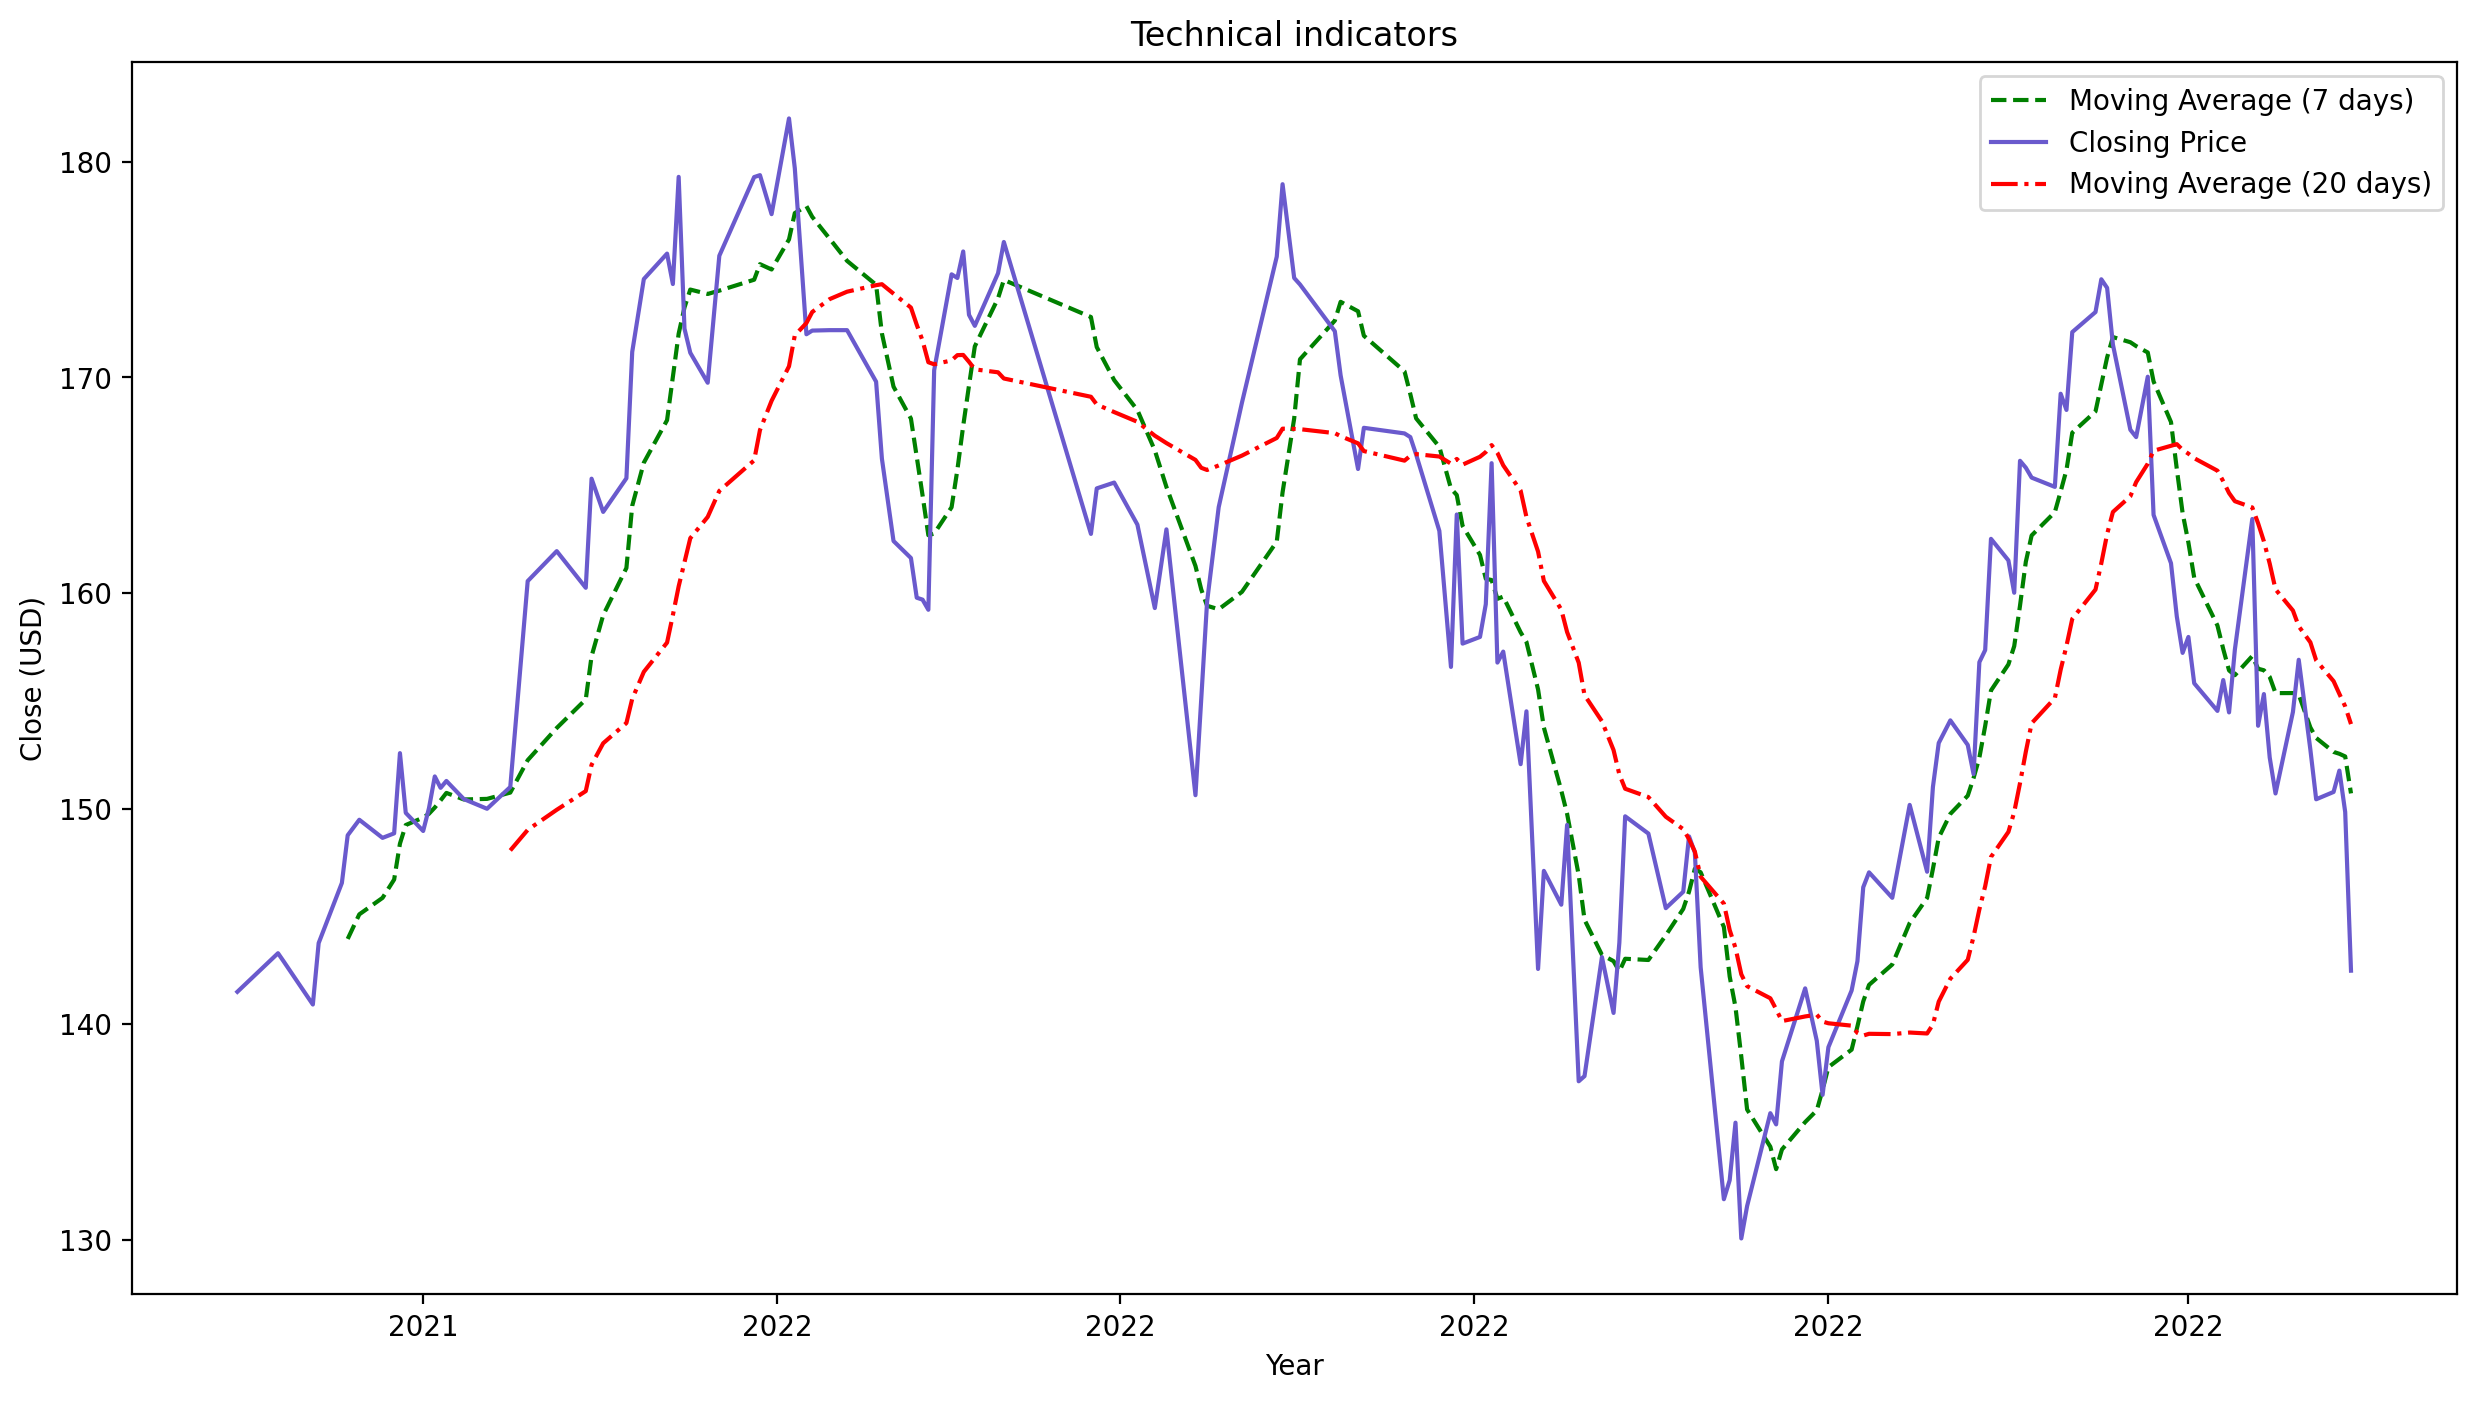

In [63]:
tech_ind(tech_df)

In [232]:
# Forward fill method on missing  values( if any)
AAPL_ds.iloc[:, 1:] = pd.concat([AAPL_ds.iloc[:, 1:].ffill()])


In [233]:
datetime_series = pd.to_datetime(AAPL_ds['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = AAPL_ds.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
AAPL_ds = dataset.drop(columns='Date')

#We set the index for the rows of the data to be the date.

In [234]:
AAPL_ds.head() # Visulize the data

,Open,High,Low,Close,Adj Close,Volume,Stock Name,Mean_sentiment_intraday,Min_sentiment_intraday,Max_sentiment_intraday,...,market_movement,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum,RSI
2021-11-19,157.649994,161.020004,156.529999,160.550003,159.623566,117305600,AAPL,0.8159,0.8159,0.8159,...,1,152.244289,149.010001,-0.279722,4.225760,157.461522,140.558481,157.280129,5.072357,74.229377
2021-11-24,160.750000,162.139999,159.639999,161.940002,161.005569,69463600,AAPL,-0.10705,-0.4404,0.2263,...,0,153.737146,149.942502,-0.790862,4.900909,159.744319,140.140684,160.386711,5.081032,74.920029
2021-11-29,159.369995,161.190002,158.789993,160.240005,159.315369,88748200,AAPL,0.3612,0.3612,0.3612,...,0,155.062860,150.809502,-1.111753,5.118424,161.046351,140.572654,160.288907,5.070413,72.428485
2021-11-30,159.990005,165.520004,159.919998,165.300003,164.346176,174048100,AAPL,0.7096,0.7096,0.7096,...,0,157.065717,152.029002,-0.993084,5.525053,163.079109,140.978896,163.629638,5.101694,76.782823
2021-12-02,158.740005,164.199997,157.800003,163.759995,162.815063,136739200,AAPL,0.10115,0.0,0.2023,...,0,158.968573,153.029002,-0.771967,5.754804,164.538611,141.519394,163.716542,5.092277,69.610925


In [235]:
AAPL_ds.drop(['Adj Close', 'Stock Name'], axis=1, inplace=True) # This value is quite similar to the CLOSE, to avoid data leakage, we remove it.
 

In [236]:
AAPL_ds.drop(['close_pct_change', 'open_close_diff'], axis=1, inplace=True) #Similar reason as above
AAPL_ds.head()

,Open,High,Low,Close,Volume,Mean_sentiment_intraday,Min_sentiment_intraday,Max_sentiment_intraday,Mean_sentiment_before_sod,Min_sentiment_before_sod,...,market_movement,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum,RSI
2021-11-19,157.649994,161.020004,156.529999,160.550003,117305600,0.8159,0.8159,0.8159,0.363591,0.0,...,1,152.244289,149.010001,-0.279722,4.225760,157.461522,140.558481,157.280129,5.072357,74.229377
2021-11-24,160.750000,162.139999,159.639999,161.940002,69463600,-0.10705,-0.4404,0.2263,0.166817,-0.128,...,0,153.737146,149.942502,-0.790862,4.900909,159.744319,140.140684,160.386711,5.081032,74.920029
2021-11-29,159.369995,161.190002,158.789993,160.240005,88748200,0.3612,0.3612,0.3612,0.132742,-0.9062,...,0,155.062860,150.809502,-1.111753,5.118424,161.046351,140.572654,160.288907,5.070413,72.428485
2021-11-30,159.990005,165.520004,159.919998,165.300003,174048100,0.7096,0.7096,0.7096,0.154812,-0.6808,...,0,157.065717,152.029002,-0.993084,5.525053,163.079109,140.978896,163.629638,5.101694,76.782823
2021-12-02,158.740005,164.199997,157.800003,163.759995,136739200,0.10115,0.0,0.2023,0.032713,-0.663,...,0,158.968573,153.029002,-0.771967,5.754804,164.538611,141.519394,163.716542,5.092277,69.610925


In [237]:
#Check the dtypes of the columns

AAPL_ds.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 154 entries, 2021-11-19 to 2022-09-29
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Open                       154 non-null    float64
 1   High                       154 non-null    float64
 2   Low                        154 non-null    float64
 3   Close                      154 non-null    float64
 4   Volume                     154 non-null    int64  
 5   Mean_sentiment_intraday    154 non-null    object 
 6   Min_sentiment_intraday     154 non-null    object 
 7   Max_sentiment_intraday     154 non-null    object 
 8   Mean_sentiment_before_sod  154 non-null    object 
 9   Min_sentiment_before_sod   154 non-null    object 
 10  Max_sentiment_before_sod   154 non-null    object 
 11  vol_pct_change             154 non-null    float64
 12  high_low_diff              154 non-null    float64
 13  market_movement            154 

In [238]:
# Scale the data
df=AAPL_ds
scaling_range=(-1, 1)
target='Close'
Scaler=MinMaxScaler(feature_range=scaling_range)

# Fit the scalers
Scaler.fit(df)

# Transform the data
Scaled_df=Scaler.transform(df)
Scaled_df=pd.DataFrame(Scaled_df, columns=df.columns)

# Seperate the target out
Y=Scaled_df['Close']
X=Scaled_df.drop(columns=['Close'])


In [82]:
Scaled_df.head() #Check if the data is scaled.

,Open,High,Low,Close,Volume,Mean_sentiment_intraday,Min_sentiment_intraday,Max_sentiment_intraday,Mean_sentiment_before_sod,Min_sentiment_before_sod,...,market_movement,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum,RSI
0,0.049467,0.132740,0.097844,0.173821,-0.083485,0.852483,0.852483,0.835196,0.640808,0.280077,...,1.0,-0.150569,-0.452493,-0.173522,-0.762475,-0.636310,-0.311868,0.046880,0.253891,0.664819
1,0.167427,0.177052,0.222045,0.227334,-0.746969,-0.129849,-0.484647,0.213518,0.362267,0.114756,...,0.0,-0.083728,-0.398981,-0.246954,-0.570987,-0.509065,-0.333398,0.173516,0.305177,0.684477
2,0.114916,0.139466,0.188099,0.161887,-0.479525,0.368527,0.368527,0.355757,0.314033,-0.890345,...,0.0,-0.024370,-0.349229,-0.293054,-0.509294,-0.436488,-0.311138,0.169529,0.242393,0.613561
3,0.138508,0.310782,0.233227,0.356689,0.703433,0.739343,0.739343,0.723113,0.345275,-0.599225,...,0.0,0.065307,-0.279248,-0.276005,-0.393965,-0.323181,-0.290204,0.305709,0.427340,0.737496
4,0.090944,0.258556,0.148563,0.297401,0.186025,0.091746,-0.015912,0.188212,0.172439,-0.576235,...,0.0,0.150505,-0.221863,-0.244239,-0.328802,-0.241827,-0.262352,0.309252,0.371661,0.533367


In [240]:

#Train test Split 
split_index = int(len(df) * 0.8)  # 80% for training, 20% for testing

# Split the dataset
X_train_aapl, X_test_aapl = X.iloc[:split_index], X.iloc[split_index:]
Y_train_aapl, Y_test_aapl = Y.iloc[:split_index], Y.iloc[split_index:]

#Get the date to ease the ploting process 
datetime_train_aapl = datetime_index[:split_index]
datetime_test_aapl= datetime_index[split_index:]

# Verify the shapes of the datasets
print(X_train_aapl.shape)
print(X_test_aapl.shape)
print(Y_train_aapl.shape)
print(Y_test_aapl.shape)


(123, 22)
(31, 22)
(123,)
(31,)


In [241]:
X_train_aapl.head()

,Open,High,Low,Volume,Mean_sentiment_intraday,Min_sentiment_intraday,Max_sentiment_intraday,Mean_sentiment_before_sod,Min_sentiment_before_sod,Max_sentiment_before_sod,...,market_movement,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum,RSI
0,0.049467,0.132740,0.097844,-0.083485,0.852483,0.852483,0.835196,0.640808,0.280077,0.928508,...,1.0,-0.150569,-0.452493,-0.173522,-0.762475,-0.636310,-0.311868,0.046880,0.253891,0.664819
1,0.167427,0.177052,0.222045,-0.746969,-0.129849,-0.484647,0.213518,0.362267,0.114756,0.711796,...,0.0,-0.083728,-0.398981,-0.246954,-0.570987,-0.509065,-0.333398,0.173516,0.305177,0.684477
2,0.114916,0.139466,0.188099,-0.479525,0.368527,0.368527,0.355757,0.314033,-0.890345,0.933337,...,0.0,-0.024370,-0.349229,-0.293054,-0.509294,-0.436488,-0.311138,0.169529,0.242393,0.613561
3,0.138508,0.310782,0.233227,0.703433,0.739343,0.739343,0.723113,0.345275,-0.599225,0.964195,...,0.0,0.065307,-0.279248,-0.276005,-0.393965,-0.323181,-0.290204,0.305709,0.427340,0.737496
4,0.090944,0.258556,0.148563,0.186025,0.091746,-0.015912,0.188212,0.172439,-0.576235,0.950886,...,0.0,0.150505,-0.221863,-0.244239,-0.328802,-0.241827,-0.262352,0.309252,0.371661,0.533367


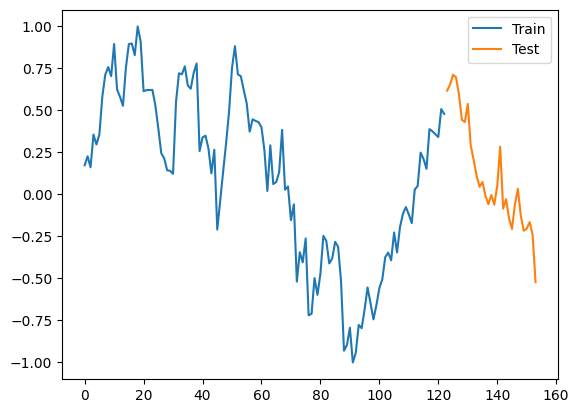

In [242]:
plt.plot(Y_train_aapl)
plt.plot(Y_test_aapl)
plt.legend(['Train','Test'])

# Model Building + Test

We will build a simple LSTM model.

In [86]:
def Lstm_model(input_shape):
    model = Sequential()

    #LSTM layer 1
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))

    # LSTM layer 2 (optional, for deeper network)
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(units=1, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    return model


In [87]:
model=Lstm_model(input_shape=(X_train.shape[1],1))

history=model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test), verbose=1) 


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - loss: 0.2626 - mae: 0.4388 - val_loss: 0.0857 - val_mae: 0.2295
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1679 - mae: 0.3408 - val_loss: 0.0658 - val_mae: 0.2126
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1245 - mae: 0.2920 - val_loss: 0.0554 - val_mae: 0.1938
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0930 - mae: 0.2489 - val_loss: 0.0474 - val_mae: 0.1680
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1005 - mae: 0.2639 - val_loss: 0.0528 - val_mae: 0.1743
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0911 - mae: 0.2537 - val_loss: 0.0478 - val_mae: 0.1590
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0743 - mae: 0.2235 - val_loss: 0.0389 - val_mae: 0.1504
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0737 - mae: 0.2310 - val_loss: 0.0355 - val_mae: 0.1485
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0725 - mae: 0.2263 -

In [100]:
# Create a function to scale it back:
scaler_y = MinMaxScaler(feature_range=(-1, 1))
y_scaled= scaler_y.fit_transform(pd.DataFrame(dataset['Close']))


In [117]:
# Verify
# Use 'scaler_y.inverse_transform'

scaler_y.inverse_transform(np.array([[-1]])) == dataset['Close'].min()

array([[ True]])

In [209]:
def create_visual():
    predicted_prices=scaler_y.inverse_transform(model.predict(X_test))
    actual_prices=scaler_y.inverse_transform(pd.DataFrame(Y_test))

    # Plot the results
    import matplotlib.pyplot as plt

    plt.figure(figsize=(14, 5))
    plt.plot(datetime_test, actual_prices, color='red', label='Actual Stock Price')
    plt.plot(datetime_test, predicted_prices, color='blue', label='Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    print('MAE: ')
    print(mean_absolute_error(predicted_prices, actual_prices))

    

# Model Tuning 

First, we will see if the technical indicators that were added in will improve the performance of the model or not. Then, we perform *hyperparameter tuning* via GridSearch to see if the model can be further improved or not.

In [107]:
#Train the model using the dataset without the technical indicator and see the performance

dataset_1=dataset.iloc[:, 0:14]
dataset_1.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 154 entries, 2021-11-19 to 2022-09-29
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Open                       154 non-null    float64
 1   High                       154 non-null    float64
 2   Low                        154 non-null    float64
 3   Close                      154 non-null    float64
 4   Volume                     154 non-null    int64  
 5   Mean_sentiment_intraday    154 non-null    object 
 6   Min_sentiment_intraday     154 non-null    object 
 7   Max_sentiment_intraday     154 non-null    object 
 8   Mean_sentiment_before_sod  154 non-null    object 
 9   Min_sentiment_before_sod   154 non-null    object 
 10  Max_sentiment_before_sod   154 non-null    object 
 11  vol_pct_change             154 non-null    float64
 12  high_low_diff              154 non-null    float64
 13  market_movement            154 

In [108]:
# Scale the data

df=dataset_1
scaling_range=(-1, 1)
target='Close'
Scaler=MinMaxScaler(feature_range=scaling_range)

# Fit the scalers
Scaler.fit(df)

# Transform the data
Scaled_df=Scaler.transform(df)
Scaled_df=pd.DataFrame(Scaled_df, columns=df.columns)

# Seperate the target out
Y=Scaled_df['Close']
X=Scaled_df.drop(columns=['Close'])

#Train test Split 
split_index = int(len(df) * 0.8)  # 80% for training, 20% for testing

# Split the dataset
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
Y_train, Y_test = Y.iloc[:split_index], Y.iloc[split_index:]

#Get the date to ease the ploting process 
datetime_train = datetime_index[:split_index]
datetime_test = datetime_index[split_index:]

# Verify the shapes of the datasets
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

model=Lstm_model(input_shape=(X_train.shape[1],1))

history=model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test), verbose=1) 


(123, 13)
(31, 13)
(123,)
(31,)
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 345ms/step - loss: 0.2786 - mae: 0.4529 - val_loss: 0.1054 - val_mae: 0.2496
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2383 - mae: 0.4190 - val_loss: 0.0944 - val_mae: 0.2405
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2100 - mae: 0.3915 - val_loss: 0.0835 - val_mae: 0.2294
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1944 - mae: 0.3759 - val_loss: 0.0756 - val_mae: 0.2178
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1516 - mae: 0.3158 - val_loss: 0.0724 - val_mae: 0.2235
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1055 - mae: 0.2509 - val_loss: 0.0827 - val_mae: 0.2511
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0922 - mae: 0.2399 - val_loss: 0.0932 - val_mae: 0.2627
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0898 - mae: 0.2353 - val_loss: 0.0608 - val_mae: 0.2125
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/ste

The mae indeed increased by 0.02, notice that the value of 0.02 is scaled, we need to inverse it back to interpret it correctly.

However, we can conclude that the model performed worse than if we consider those technical indicators.

In [120]:
scaler_y.inverse_transform(np.array([[1]]))
scaler_y.inverse_transform(np.array([[0]]))

array([[156.03499603]])

This approach is not correct, since if we have a mae of 0, which is prefect, if we convert it via inverse transform, what we will get is 156 USD of difference!

The correct method will be to convert it back to actual value and use it to calculate the Real MAE or RMSE. 

Now we will like to tune the hyperparameters for better results.

In [127]:
%pip install keras.wrappers

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement keras.wrappers (from versions: none)
ERROR: No matching distribution found for keras.wrappers


In [136]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from scikeras.wrappers import KerasRegressor

# Define the Keras model function
def create_model(optimizer='adam', dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

# Create KerasRegressor for GridSearchCV
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define parameters for grid search
param_grid = {
    'batch_size': [32, 64],
    'epochs': [50, 100],
    'optimizer': ['adam', 'rmsprop']
}

# Define your scoring method
scoring = make_scorer(mean_absolute_error, greater_is_better=False)

# Create grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, n_jobs=-1, cv=3)

# Fit grid search
grid_result = grid.fit(X_train, Y_train)

# Print best parameters and best score
print("Best parameters found: ", grid_result.best_params_)
print("Best RMSE found: ", np.sqrt(np.abs(grid_result.best_score_)))

# Evaluate model with best parameters on test set
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test)

Best parameters found:  {'batch_size': 64, 'epochs': 100, 'optimizer': 'rmsprop'}
Best RMSE found:  0.2734513979706957


In [149]:
# We wil use the parameters and try to tune the dropout rate manually.
# We cant tune the droupout together with GridSearch as it will cause errors.

def Lstm_model_1(Dropout_rate):
    model = Sequential()

    #LSTM layer 1
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
    model.add(Dropout(Dropout_rate))

    # LSTM layer 2 (optional, for deeper network)
    model.add(LSTM(units=50))
    model.add(Dropout(Dropout_rate))

    # Output layer
    model.add(Dense(units=1, activation='linear'))

    # Compile the model
    model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mae'])

    return model
model=Lstm_model_1(0.1)

history=model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_test, Y_test), verbose=1) 


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 586ms/step - loss: 0.2303 - mae: 0.4110 - val_loss: 0.0755 - val_mae: 0.2213
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1429 - mae: 0.3141 - val_loss: 0.0597 - val_mae: 0.2015
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1048 - mae: 0.2784 - val_loss: 0.0525 - val_mae: 0.1815
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0925 - mae: 0.2548 - val_loss: 0.0571 - val_mae: 0.1761
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0870 - mae: 0.2479 - val_loss: 0.0508 - val_mae: 0.1729
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0878 - mae: 0.2493 - val_loss: 0.0476 - val_mae: 0.1701
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0888 - mae: 0.2511 - val_loss: 0.0456 - val_mae: 0.1654
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0843 - mae: 0.2410 - val_loss: 0.0448 - val_mae: 0.1630
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0751 - mae:

In [148]:


model=Lstm_model_1(0.2)

history=model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_test, Y_test), verbose=1) 


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 666ms/step - loss: 0.3121 - mae: 0.4840 - val_loss: 0.1008 - val_mae: 0.2464
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2244 - mae: 0.4022 - val_loss: 0.0821 - val_mae: 0.2313
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1644 - mae: 0.3443 - val_loss: 0.0678 - val_mae: 0.2127
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1168 - mae: 0.2809 - val_loss: 0.0589 - val_mae: 0.1962
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0994 - mae: 0.2659 - val_loss: 0.0567 - val_mae: 0.1854
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0990 - mae: 0.2626 - val_loss: 0.0549 - val_mae: 0.1837
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0978 - mae: 0.2645 - val_loss: 0.0530 - val_mae: 0.1809
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0843 - mae: 0.2500 - val_loss: 0.0579 - val_mae: 0.1810
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.1045 - mae:

In [147]:
# We wil use the parameters and try to tune the dropout rate manually.
model=Lstm_model_1(0.4)

history=model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_test, Y_test), verbose=1) 


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 574ms/step - loss: 0.2749 - mae: 0.4521 - val_loss: 0.0902 - val_mae: 0.2395
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1858 - mae: 0.3637 - val_loss: 0.0718 - val_mae: 0.2219
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1381 - mae: 0.3124 - val_loss: 0.0590 - val_mae: 0.1938
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1069 - mae: 0.2816 - val_loss: 0.0602 - val_mae: 0.1829
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1054 - mae: 0.2752 - val_loss: 0.0531 - val_mae: 0.1831
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1020 - mae: 0.2633 - val_loss: 0.0530 - val_mae: 0.1735
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0967 - mae: 0.2613 - val_loss: 0.0536 - val_mae: 0.1720
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0888 - mae: 0.2529 - val_loss: 0.0476 - val_mae: 0.1660
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0834 - mae:

<\u>Best Model:<>

epochs: 100

batch size: 64

dropout rate: 0.4

optimizer: rmsprop
 

# Final Results & Graphs

## APPL

In [243]:
# Use the dataset with technical indicators

# Access the stored value to avoid confusion
X_train, X_test= X_train_aapl, X_test_aapl
Y_train, Y_test= Y_train_aapl, Y_test_aapl
datetime_test= datetime_test_aapl

'''# Verify the shapes of the datasets
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)'''

model=Lstm_model_1(0.4)

history=model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_test, Y_test), verbose=1) 


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.2043 - mae: 0.3873 - val_loss: 0.0654 - val_mae: 0.2079
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1214 - mae: 0.2885 - val_loss: 0.0518 - val_mae: 0.1816
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0953 - mae: 0.2647 - val_loss: 0.0473 - val_mae: 0.1657
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0850 - mae: 0.2441 - val_loss: 0.0475 - val_mae: 0.1653
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0931 - mae: 0.2550 - val_loss: 0.0443 - val_mae: 0.1688
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0831 - mae: 0.2436 - val_loss: 0.0414 - val_mae: 0.1579
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0884 - mae: 0.2541 - val_loss: 0.0430 - val_mae: 0.1546
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0774 - mae: 0.2331 - val_loss: 0.0387 - val_mae: 0.1512
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0743 - ma

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


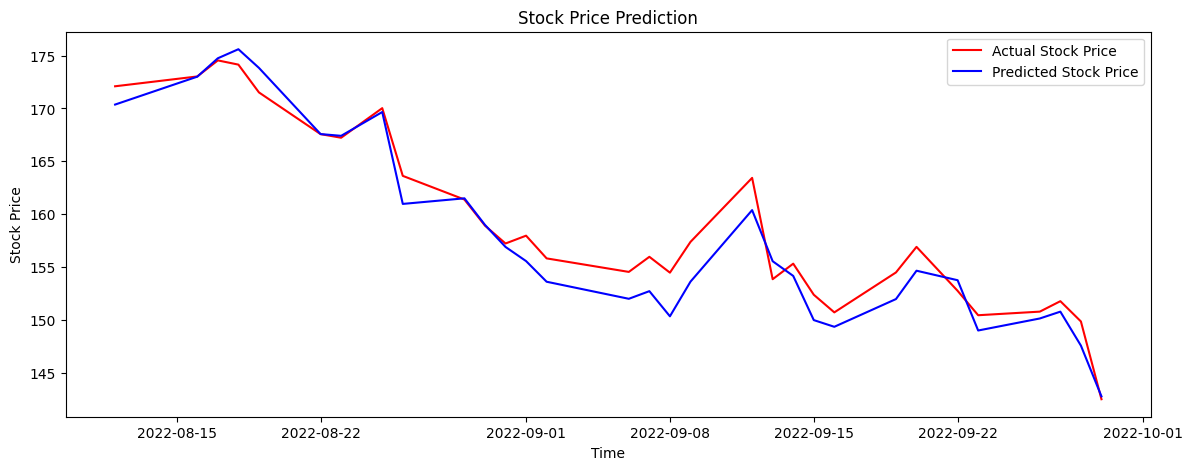

MAE: 
1.5756609516759073


In [244]:
datetime_test= datetime_test_aapl
create_visual()

## TSLA

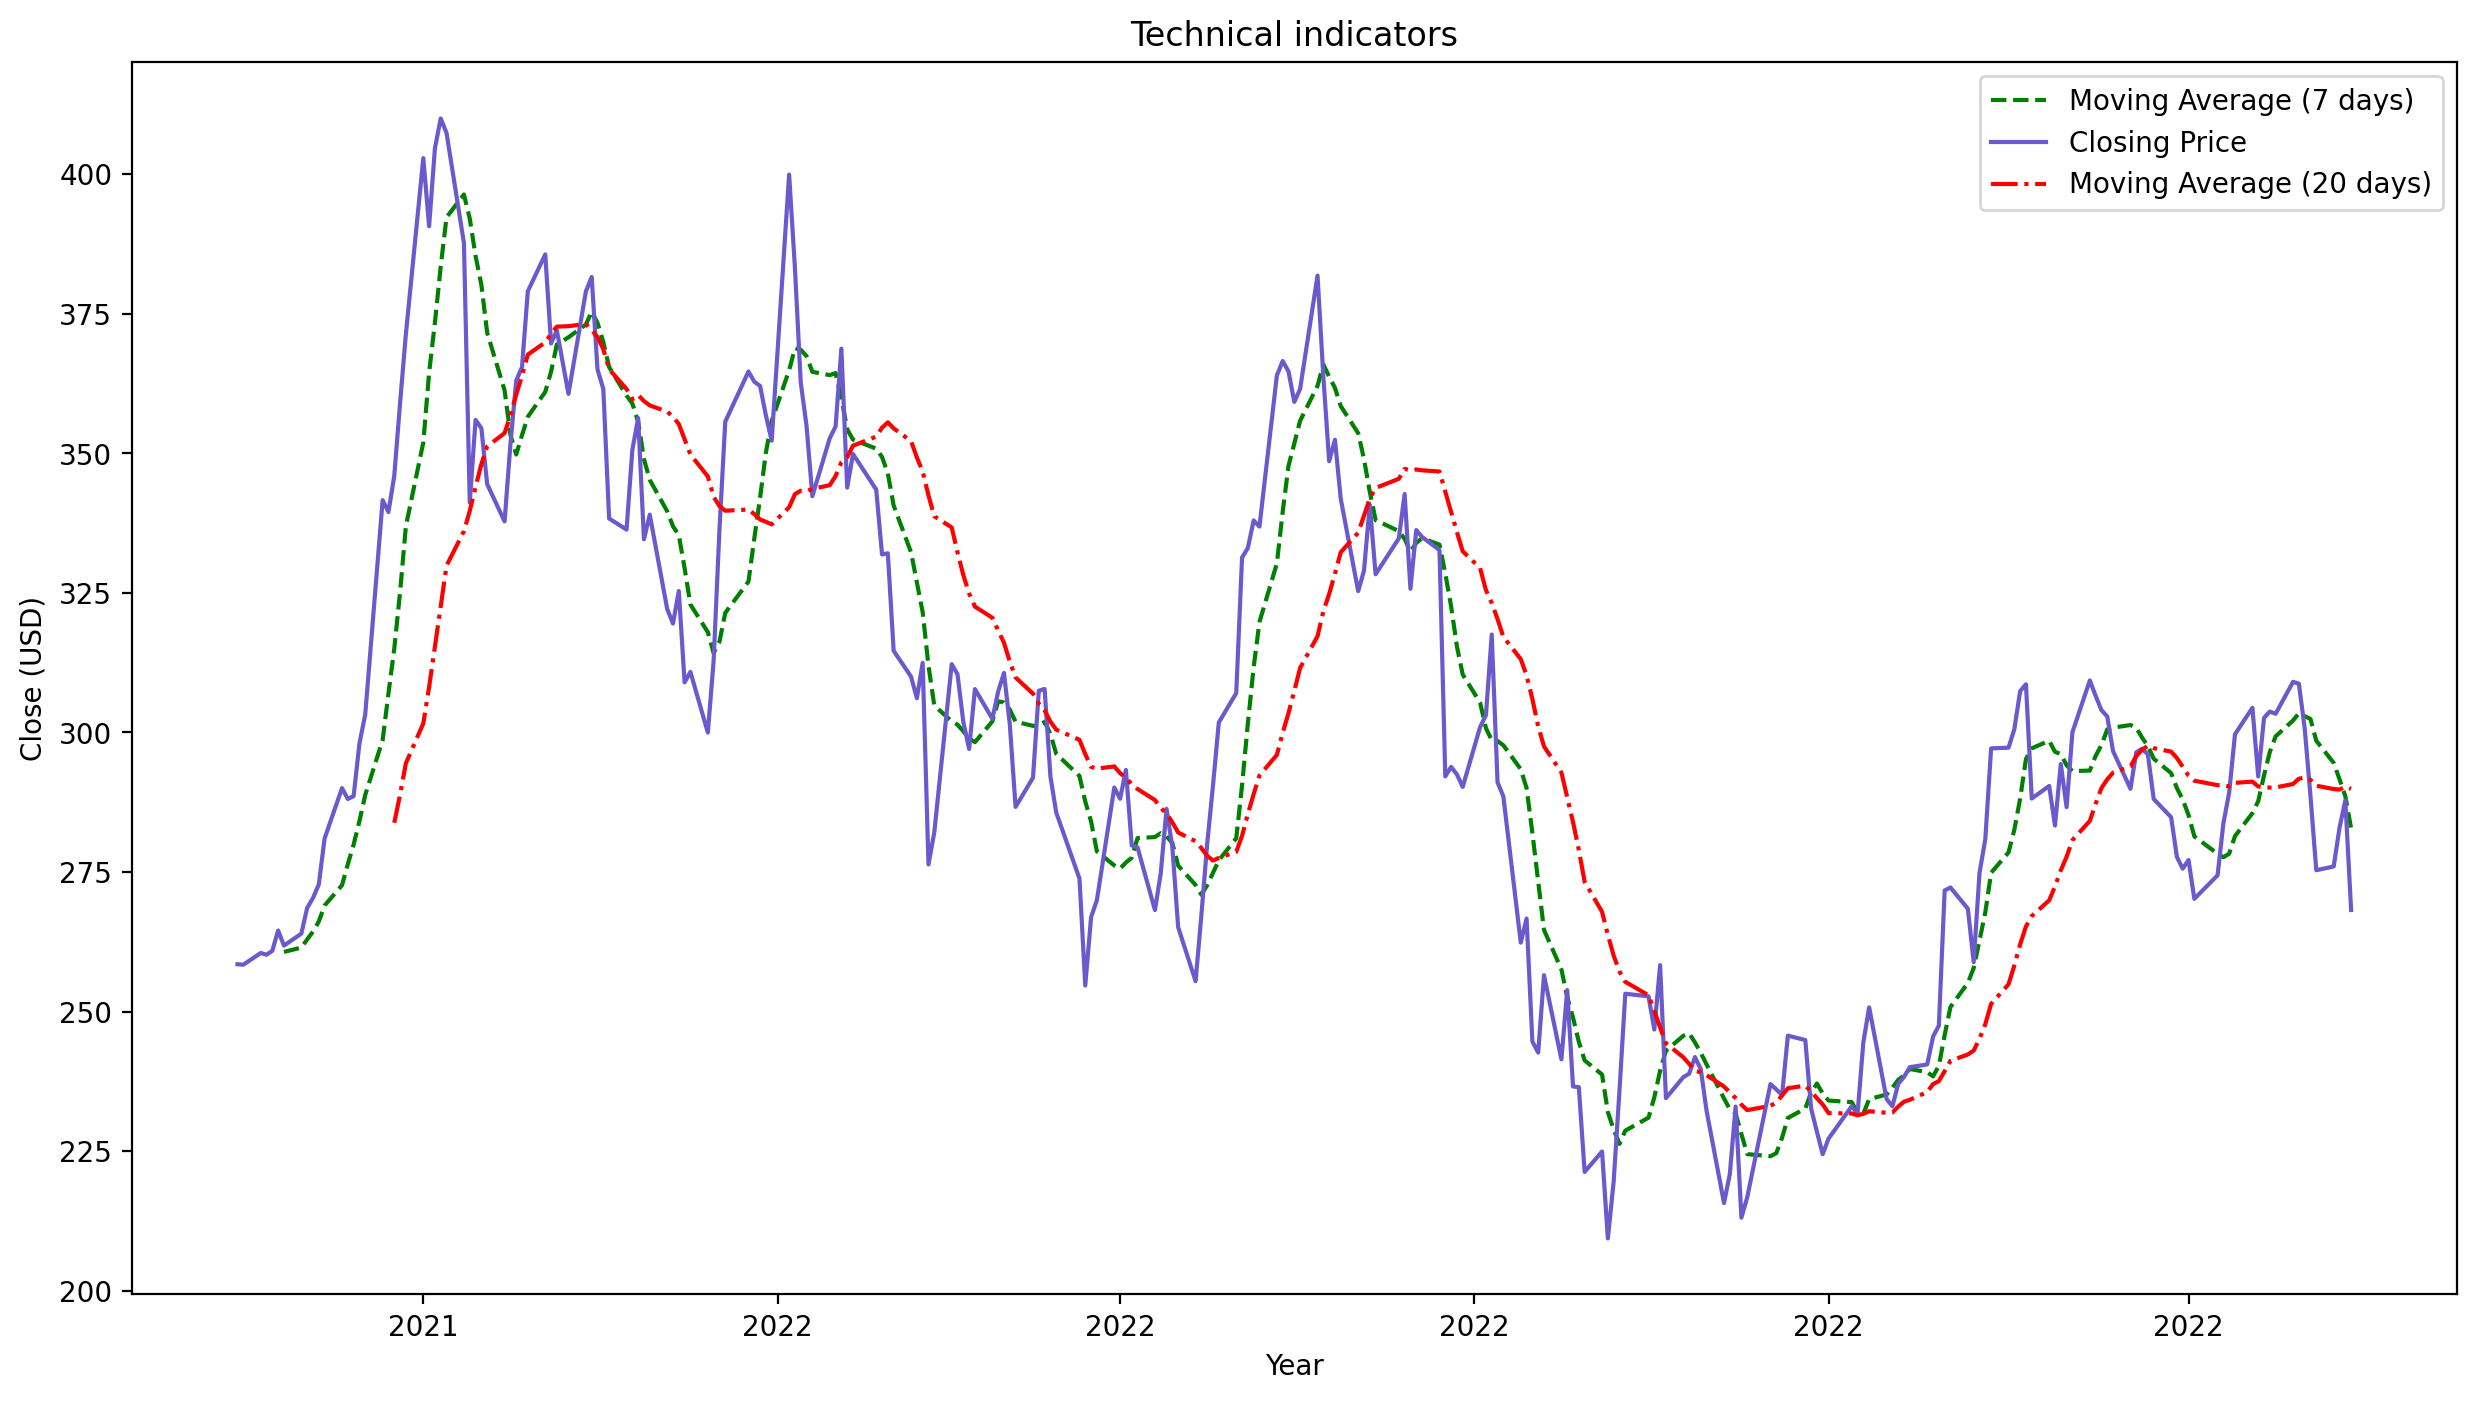

In [225]:
data=TSLA
# data.drop(columns='level_0', inplace=True)
tech_df = get_tech_ind(data)
dataset = tech_df.iloc[20:,:].reset_index(drop=True)
# tech_df.drop(columns='index',inplace=True)
tech_ind(tech_df) # Plot MA grpah

# Just repeat the same code on the different dataset
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')
dataset.drop(['Adj Close','close_pct_change', 'open_close_diff'], axis=1, inplace=True)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 451ms/step - loss: 0.2589 - mae: 0.4384 - val_loss: 0.0120 - val_mae: 0.0901
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.1389 - mae: 0.3118 - val_loss: 0.0208 - val_mae: 0.1224
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0591 - mae: 0.1935 - val_loss: 0.0587 - val_mae: 0.2084
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0498 - mae: 0.1780 - val_loss: 0.0252 - val_mae: 0.1301
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0502 - mae: 0.1790 - val_loss: 0.0305 - val_mae: 0.1475
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0508 - mae: 0.1817 - val_loss: 0.0209 - val_mae: 0.1173
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0499 - mae: 0.1791 - val_loss: 0.0468 - val_mae: 0.1871
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0489 - mae: 0.1804 - val_loss: 0.0234 - val_mae: 0.1264
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0452 - mae:

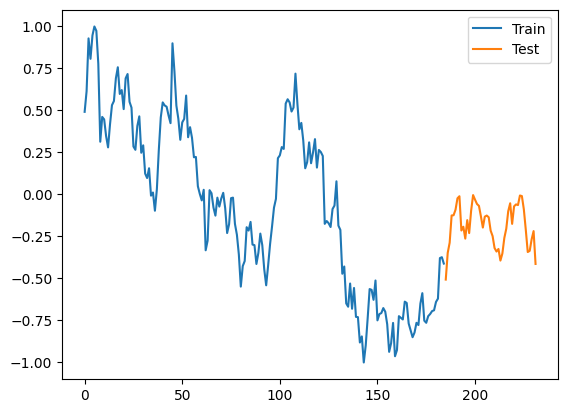

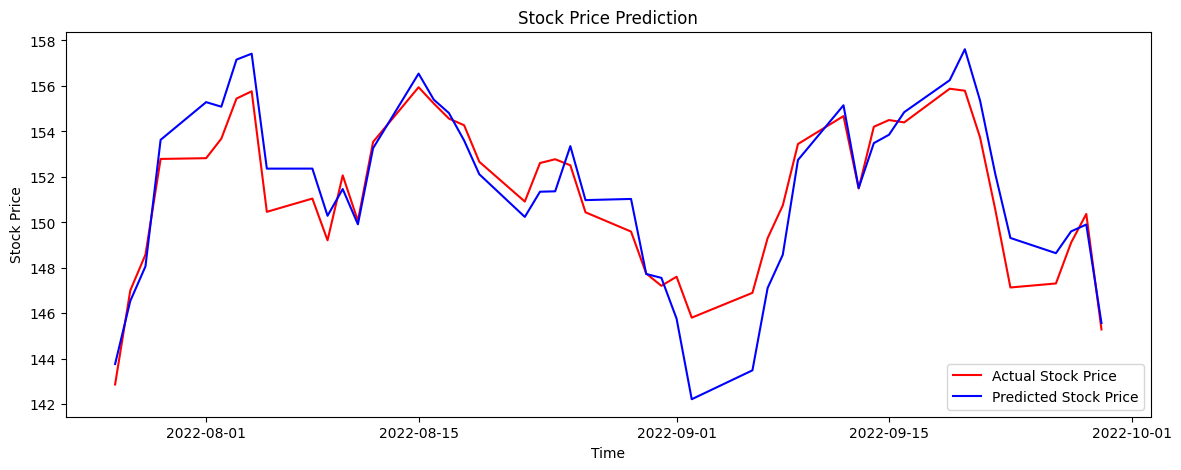

MAE: 
1.0718973571029744


In [226]:

# Scale the data
df=dataset.drop(columns=['Stock Name'])
scaling_range=(-1, 1)
target='Close'
Scaler=MinMaxScaler(feature_range=scaling_range)

# Fit the scalers
Scaler.fit(df)

    # Transform the data
Scaled_df=Scaler.transform(df)
Scaled_df=pd.DataFrame(Scaled_df, columns=df.columns)

    # Seperate the target out
Y=Scaled_df['Close']
X=Scaled_df.drop(columns=['Close'])

    #Train test Split 
split_index = int(len(df) * 0.8)  # 80% for training, 20% for testing

    # Split the dataset
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
Y_train, Y_test = Y.iloc[:split_index], Y.iloc[split_index:]

    #Get the date to ease the ploting process 
datetime_train = datetime_index[:split_index]
datetime_test = datetime_index[split_index:]

    # Plot
plt.plot(Y_train)
plt.plot(Y_test)
plt.legend(['Train','Test'])

model=Lstm_model_1(0.4)

history=model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_test, Y_test), verbose=1) 
create_visual()


## GOOG

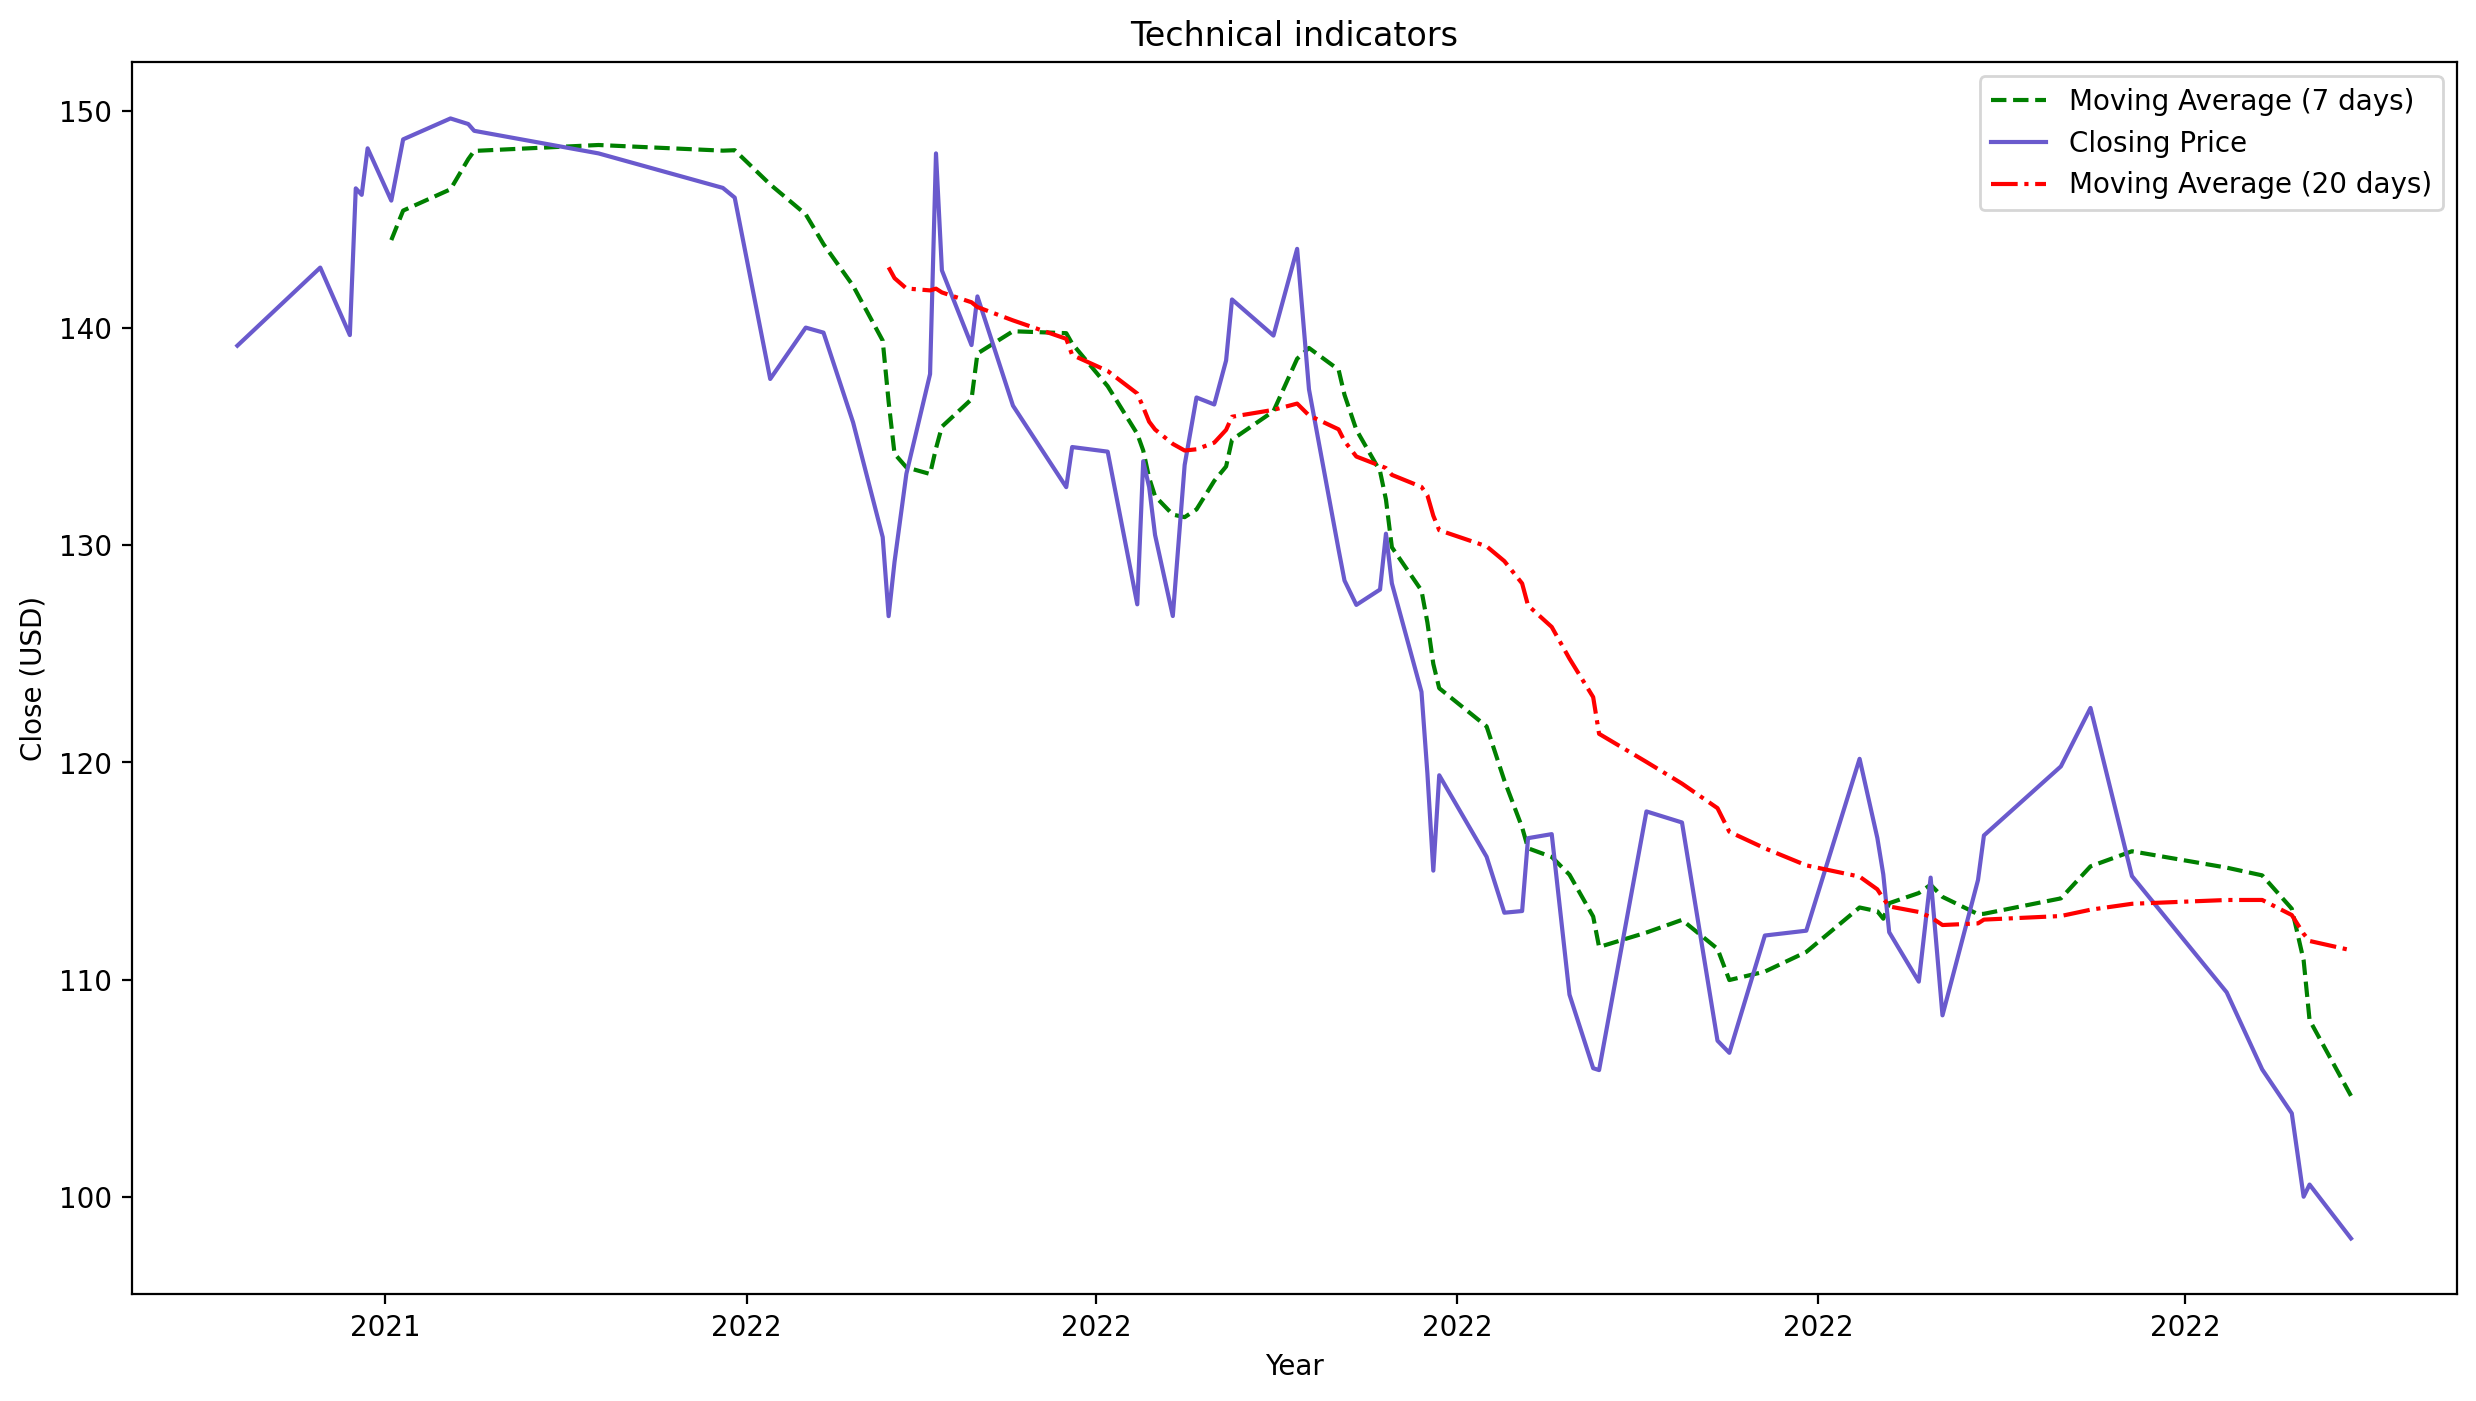

In [228]:
# Repeat the same code on the GOOG dataset.

data=GOOG
# Already removed
# data.drop(columns='level_0', inplace=True)
tech_df = get_tech_ind(data)
dataset = tech_df.iloc[20:,:].reset_index(drop=True)
# tech_df.drop(columns='index',inplace=True)
tech_ind(tech_df) # Plot MA grpah

dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')
dataset.drop(['Adj Close','close_pct_change', 'open_close_diff'], axis=1, inplace=True)


In [229]:
# Scale the data
df=dataset.drop(['Stock Name'], axis=1)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.2223 - mae: 0.4165 - val_loss: 0.2824 - val_mae: 0.4581
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step - loss: 0.1612 - mae: 0.3548 - val_loss: 0.2178 - val_mae: 0.3953
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.1403 - mae: 0.3247 - val_loss: 0.1514 - val_mae: 0.3219
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.1145 - mae: 0.2877 - val_loss: 0.0981 - val_mae: 0.2642
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0933 - mae: 0.2565 - val_loss: 0.0679 - val_mae: 0.2151
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0878 - mae: 0.2501 - val_loss: 0.0645 - val_mae: 0.2038
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0803 - mae: 0.2381 - val_loss: 0.0686 - val_mae: 0.2067
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0801 - mae: 0.2307 - val_loss: 0.0740 - val_mae: 0.2153
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0822 -

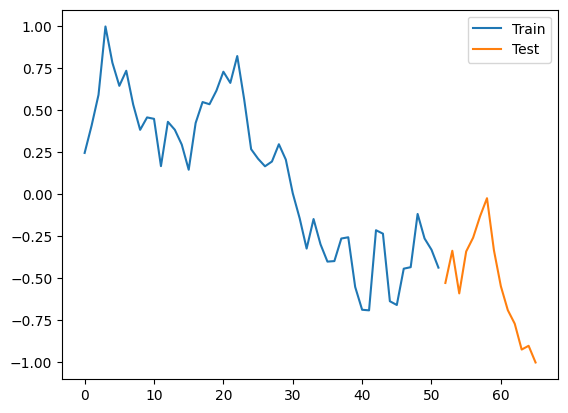

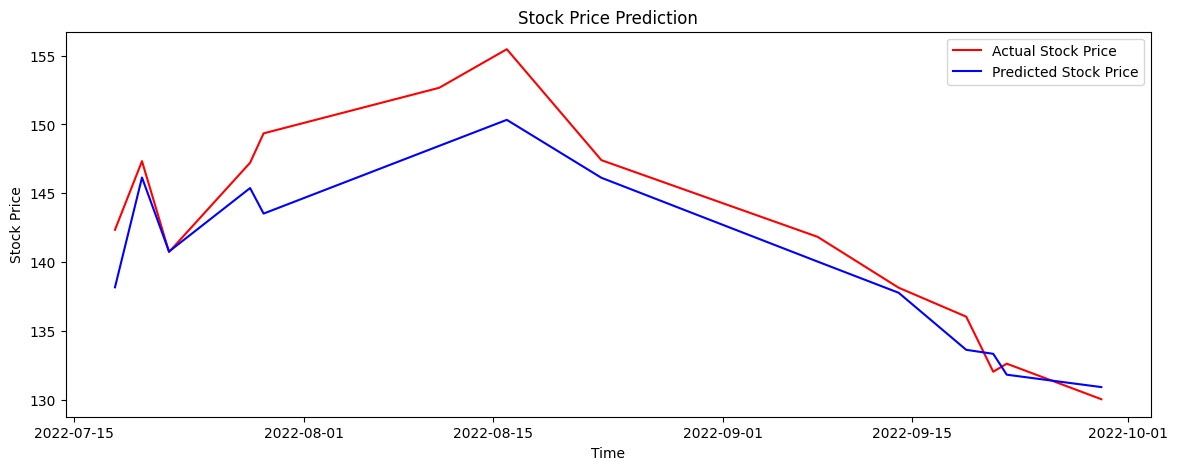

MAE: 
2.230234992800015


In [230]:
df=dataset
scaling_range=(-1, 1)
target='Close'
Scaler=MinMaxScaler(feature_range=scaling_range)

# Fit the scalers
Scaler.fit(df)

    # Transform the data
Scaled_df=Scaler.transform(df)
Scaled_df=pd.DataFrame(Scaled_df, columns=df.columns)

    # Seperate the target out
Y=Scaled_df['Close']
X=Scaled_df.drop(columns=['Close'])

    #Train test Split 
split_index = int(len(df) * 0.8)  # 80% for training, 20% for testing

    # Split the dataset
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
Y_train, Y_test = Y.iloc[:split_index], Y.iloc[split_index:]

    #Get the date to ease the ploting process 
datetime_train = datetime_index[:split_index]
datetime_test = datetime_index[split_index:]

    # Plot
plt.plot(Y_train)
plt.plot(Y_test)
plt.legend(['Train','Test'])

model=Lstm_model_1(0.4)

history=model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_test, Y_test), verbose=1) 
create_visual()
